In [3]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [6]:
with zipfile.ZipFile(base_path + 'Entropion.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [7]:
splitfolders.ratio('/content/Entropion', output = 'Entropion_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 19174 files [00:03, 5984.53 files/s]


## Zero-Centering

In [27]:
train_path = '/content/Entropion_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [28]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [29]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [30]:
mean_img

array([[[102.2752461 , 113.02972814, 122.93206858],
        [102.27029141, 113.04980768, 122.93989178],
        [102.19434122, 112.93161223, 122.86830954],
        ...,
        [104.98070278, 116.07256014, 125.53360715],
        [105.04778669, 116.09655127, 125.59345459],
        [105.14322968, 116.20777104, 125.68257383]],

       [[102.09094465, 112.81113502, 122.73890084],
        [102.19303736, 112.97203208, 122.86720125],
        [102.1235413 , 112.86224656, 122.807419  ],
        ...,
        [104.96922876, 116.05411044, 125.52493644],
        [105.02666406, 116.06571484, 125.5729839 ],
        [105.12908273, 116.22133125, 125.68524676]],

       [[101.99843536, 112.73114284, 122.67005672],
        [101.97255362, 112.74470304, 122.65160701],
        [101.96681661, 112.70421801, 122.66138601],
        ...,
        [104.85429298, 115.94439012, 125.44103266],
        [105.03742095, 116.07549384, 125.59619271],
        [105.09055349, 116.16409153, 125.64926006]],

       ...,

      

In [31]:
with open('/content/drive/MyDrive/image_recognition/data/image_data/binary_train_pickle/Entropion_mean.pickle', 'wb') as f:
    pickle.dump(mean_img, f, pickle.HIGHEST_PROTOCOL)

# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)
# data

In [ ]:
batch_size = 128

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/Entropion_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/Entropion_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/Entropion_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 15339 images belonging to 2 classes.
Found 1916 images belonging to 2 classes.
Found 1919 images belonging to 2 classes.


In [ ]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50 = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
s_model_res50.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [ ]:
  history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
120/120 [==============================] - 78s 505ms/step - loss: 1.2591 - accuracy: 0.7841 - recall: 0.7458 - val_loss: 0.3159 - val_accuracy: 0.9034 - val_recall: 0.9195
Epoch 2/10
120/120 [==============================] - 58s 483ms/step - loss: 0.2656 - accuracy: 0.8890 - recall: 0.8685 - val_loss: 0.2038 - val_accuracy: 0.9118 - val_recall: 0.8746
Epoch 3/10
120/120 [==============================] - 58s 478ms/step - loss: 0.2445 - accuracy: 0.9010 - recall: 0.8829 - val_loss: 0.1823 - val_accuracy: 0.9243 - val_recall: 0.8986
Epoch 4/10
120/120 [==============================] - 58s 480ms/step - loss: 0.2047 - accuracy: 0.9176 - recall: 0.9059 - val_loss: 0.1802 - val_accuracy: 0.9212 - val_recall: 0.9342
Epoch 5/10
120/120 [==============================] - 58s 478ms/step - loss: 0.1891 - accuracy: 0.9233 - recall: 0.9151 - val_loss: 0.1690 - val_accuracy: 0.9275 - val_recall: 0.9310
Epoch 6/10
120/120 [==============================] - 58s 480ms/step - loss: 0.1826 -

dict_keys(['loss', 'accuracy', 'recall', 'val_loss', 'val_accuracy', 'val_recall'])

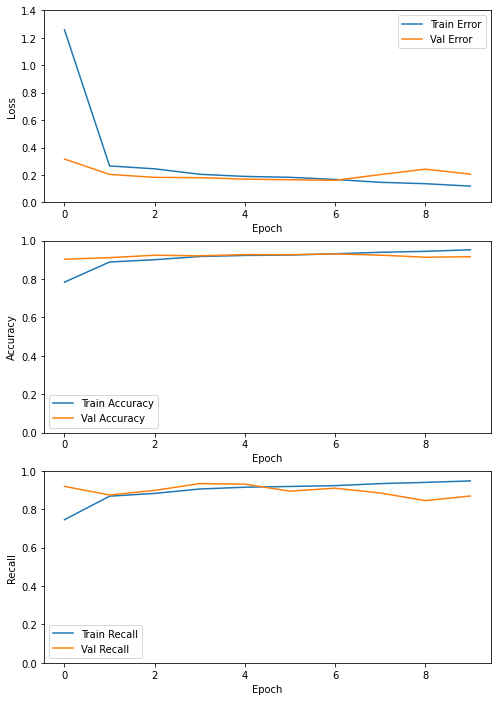

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

In [17]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [18]:
with zipfile.ZipFile(base_path + 'epiphora.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [19]:
splitfolders.ratio('/content/epiphora', output = 'epiphora_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 19201 files [00:02, 6480.71 files/s]


## Zero-Centering

In [20]:
train_path = '/content/epiphora_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [21]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [22]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [26]:
mean_img

array([[[114.04700521, 126.0984375 , 138.19485677],
        [114.00449219, 126.08033854, 138.15683594],
        [113.8641276 , 125.91927083, 138.04433594],
        ...,
        [118.27571615, 130.86751302, 142.15970052],
        [118.40540365, 130.94485677, 142.27604167],
        [118.54433594, 131.08339844, 142.37871094]],

       [[113.9516276 , 125.9734375 , 138.09420573],
        [113.81158854, 125.88984375, 137.97623698],
        [113.728125  , 125.77825521, 137.91601562],
        ...,
        [118.3421224 , 130.91764323, 142.21614583],
        [118.29544271, 130.82311198, 142.15371094],
        [118.46132812, 131.01477865, 142.29505208]],

       [[113.74121094, 125.77877604, 137.90917969],
        [113.57539062, 125.66308594, 137.76529948],
        [113.64199219, 125.68789062, 137.85136719],
        ...,
        [118.25442708, 130.83470052, 142.14505208],
        [118.27519531, 130.80136719, 142.13378906],
        [118.37923177, 130.93222656, 142.2219401 ]],

       ...,

      

In [23]:
with open('/content/drive/MyDrive/image_recognition/data/image_data/binary_train_pickle/epiphora_mean.pickle', 'wb') as f:
    pickle.dump(mean_img, f, pickle.HIGHEST_PROTOCOL)

# with open('data.pickle', 'rb') as f:
#     data = pickle.load(f)
# data

In [ ]:
batch_size = 128

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/epiphora_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/epiphora_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/epiphora_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 15360 images belonging to 2 classes.
Found 1920 images belonging to 2 classes.
Found 1921 images belonging to 2 classes.


In [ ]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50 = tf.keras.Model(inputs, outputs)


In [ ]:
s_model_res50.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [ ]:
  history = s_model_res50.fit(train_generator, validation_data = val_generator, epochs = 10)

Epoch 1/10
120/120 [==============================] - 65s 500ms/step - loss: 1.4300 - accuracy: 0.6740 - recall: 0.5350 - val_loss: 0.3420 - val_accuracy: 0.8526 - val_recall: 0.8177
Epoch 2/10
120/120 [==============================] - 58s 483ms/step - loss: 0.3331 - accuracy: 0.8639 - recall: 0.8423 - val_loss: 0.2654 - val_accuracy: 0.8849 - val_recall: 0.8365
Epoch 3/10
120/120 [==============================] - 58s 479ms/step - loss: 0.2593 - accuracy: 0.8919 - recall: 0.8750 - val_loss: 0.2327 - val_accuracy: 0.8995 - val_recall: 0.9198
Epoch 4/10
120/120 [==============================] - 58s 480ms/step - loss: 0.2276 - accuracy: 0.9083 - recall: 0.9038 - val_loss: 0.2276 - val_accuracy: 0.9089 - val_recall: 0.8854
Epoch 5/10
120/120 [==============================] - 58s 480ms/step - loss: 0.2073 - accuracy: 0.9138 - recall: 0.9099 - val_loss: 0.2408 - val_accuracy: 0.8953 - val_recall: 0.9458
Epoch 6/10
120/120 [==============================] - 58s 480ms/step - loss: 0.1993 -

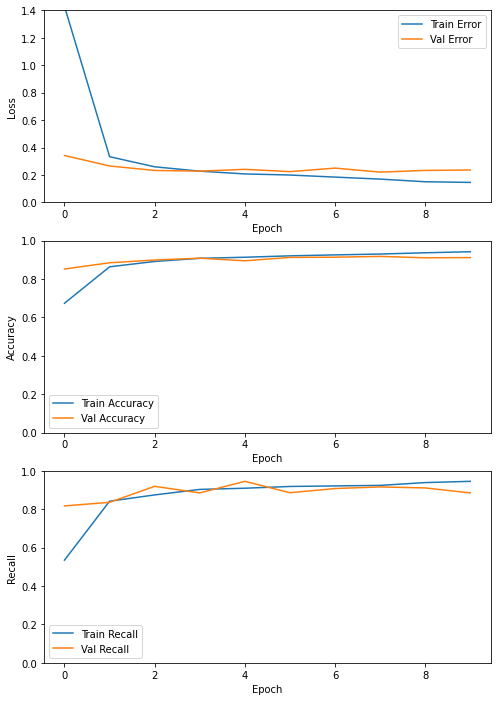

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)

In [ ]:
s_model_res50.evaluate(test_generator)

16/16 [==============================] - 7s 392ms/step - loss: 0.2165 - accuracy: 0.9178 - recall: 0.9043


[0.21651960909366608, 0.9177511930465698, 0.9042664170265198]